In [1]:
import cv2

In [2]:
import pickle
window=pickle.load(open('../data/window.pkl','rb'))
window.shape

(1000, 1000, 3)

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def normalize(window,range=[0,1],dtype=np.float32):
    _max=max(window.flatten())
    _min=min(window.flatten())
    return np.array((window-_min)/(_max-_min),dtype=dtype)


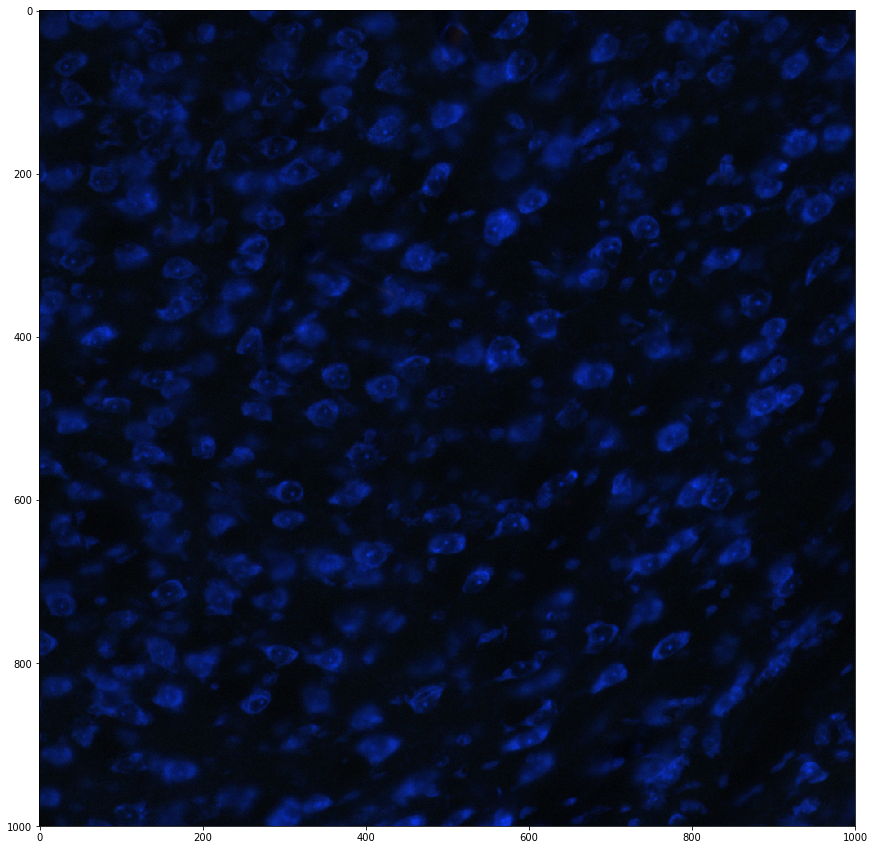

In [5]:
figure(figsize=[15,15])
imshow(normalize(window));

### checking whether 3 colors carry more information than one.

According to their histograms, they are very different

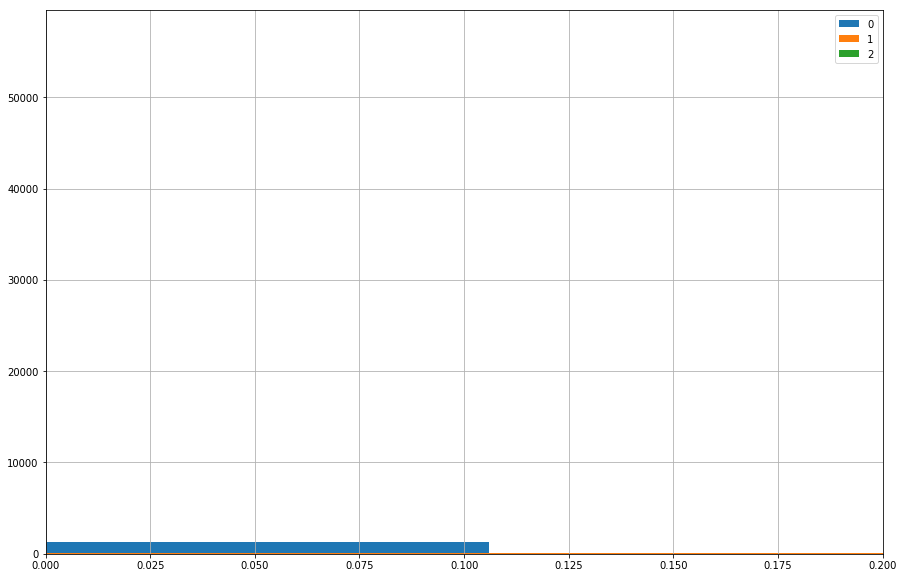

In [6]:
figure(figsize=[15,10])
for i in range(3):
    _flat=window[:,:,i].flatten()
    hist(_flat,bins=1000,label=str(i));
    xlim([0,0.2])
    #ylim([0,50000])
legend()
grid()

Text(0.5,1,'taking the mean of the 3 colors')

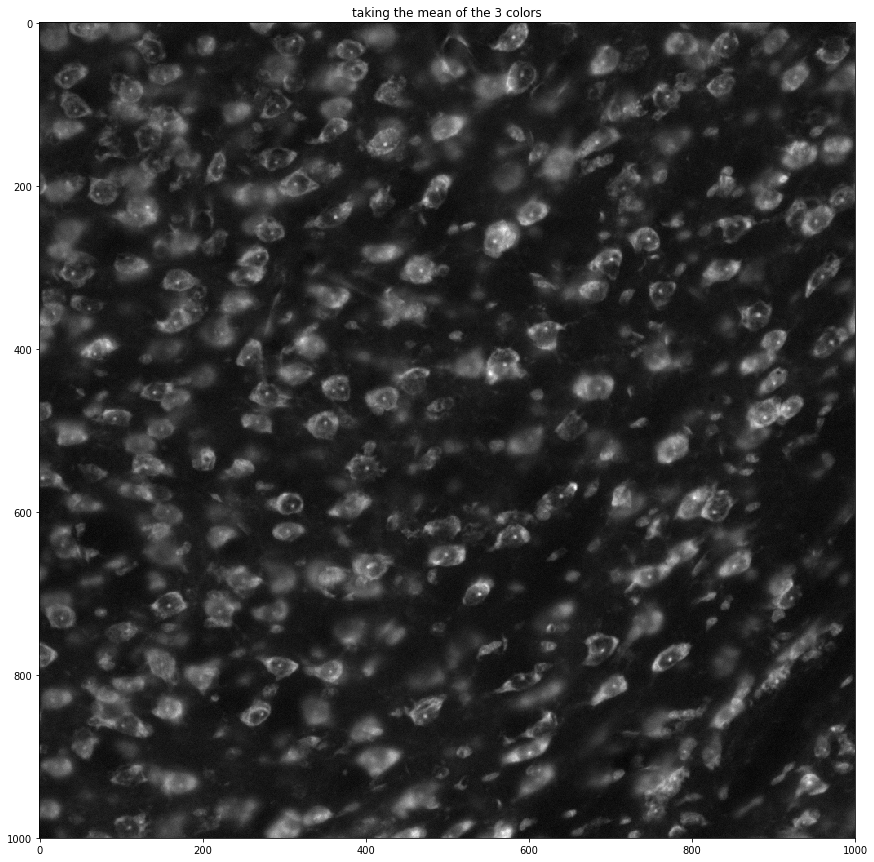

In [7]:
figure(figsize=[15,15])
_mean=normalize(np.mean(window,axis=2))
imshow(_mean,cmap='gray');
title('taking the mean of the 3 colors')

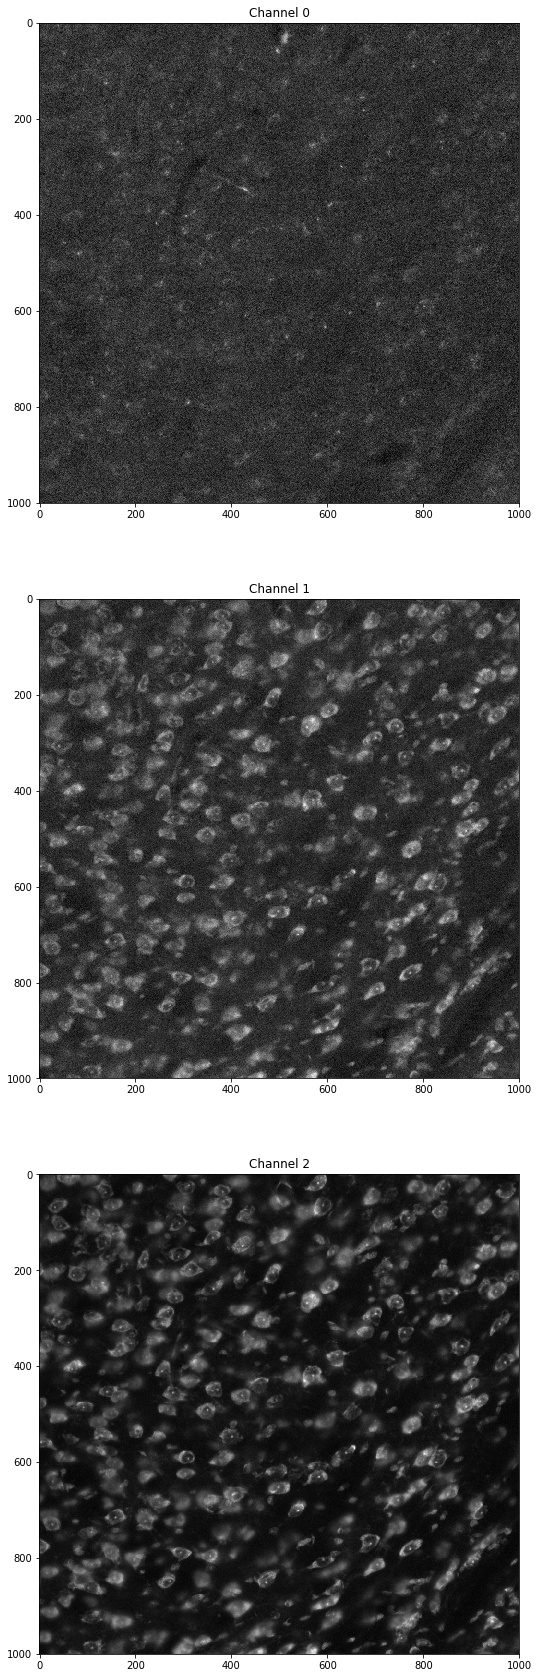

In [8]:
figure(figsize=[10,30])
for i in range(3):
    subplot(3,1,i+1)
    imshow(normalize(window[:,:,i]),cmap='gray')
    title('Channel %d'%i)

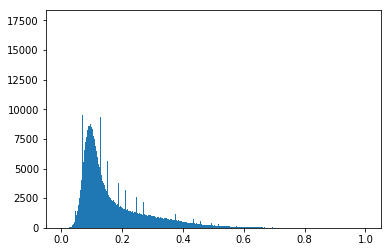

In [9]:
hist(_mean.flatten(),bins=1000);

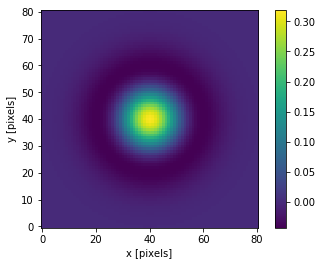

In [10]:
from astropy.convolution import MexicanHat2DKernel
mexicanhat_2D_kernel = 10000*MexicanHat2DKernel(10)
plt.imshow(mexicanhat_2D_kernel, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

In [11]:
from astropy.convolution import convolve

In [12]:
type(mexicanhat_2D_kernel)

astropy.convolution.kernels.MexicanHat2DKernel

In [13]:
P=convolve(_mean,mexicanhat_2D_kernel)

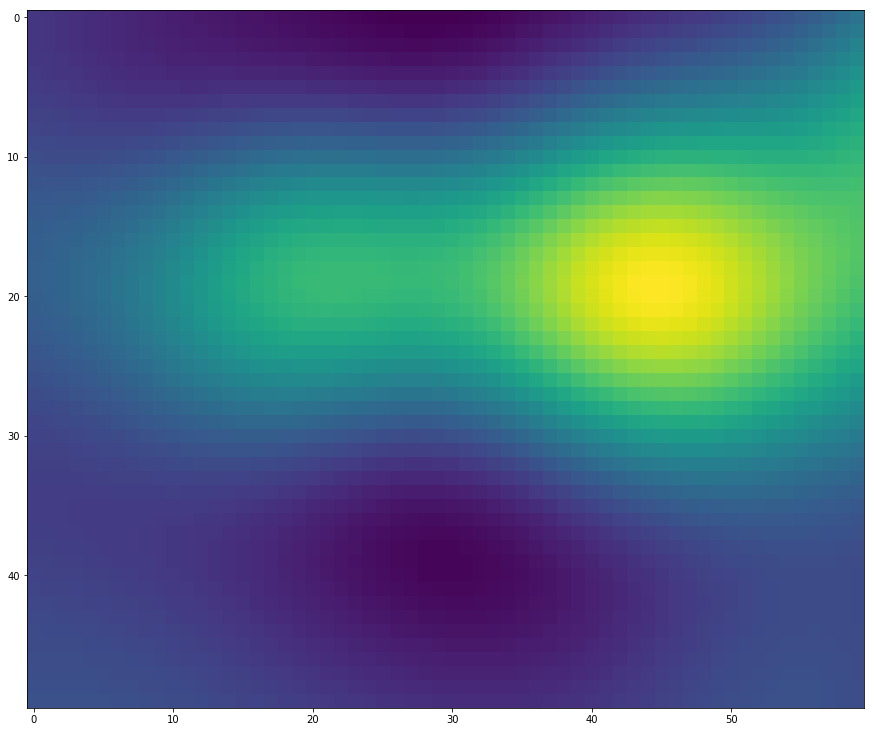

In [14]:
figure(figsize=[15,15])
imshow(P[500:550,540:600])

In [15]:
from photutils.detection import find_peaks

In [16]:
#find_peaks?

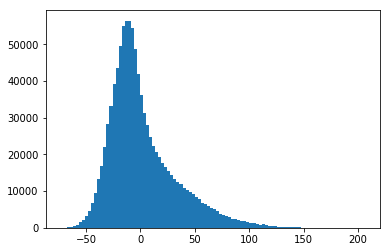

In [17]:
hist(P.flatten(),bins=100);

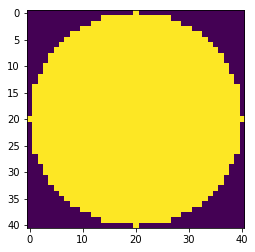

In [18]:
cell_size=41
center=(cell_size-1)/2.
footprint=np.ones([cell_size,cell_size])>1

for i in range(cell_size):
    for j in range(cell_size):
        footprint[i,j]=((i-center)**2+(j-center)**2)<=center**2
imshow(footprint)

(0, 10000)

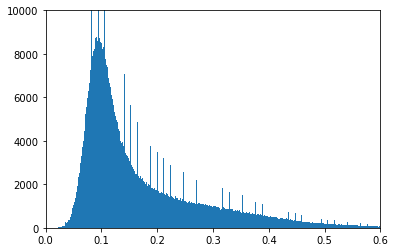

In [19]:
hist(_mean.flatten(),bins=1000);
xlim([0,0.6])
ylim([0,10000])

In [20]:
Peaks=find_peaks(P,0.4,footprint=footprint)
len(Peaks)

364

In [21]:
window.shape

(1000, 1000, 3)

In [22]:
type(_mean[0,0])

numpy.float32

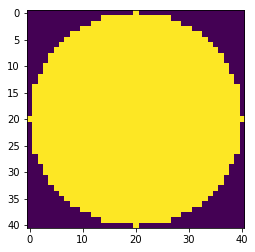

In [23]:
markers=_mean*np.float32(0)
stamp=np.zeros([cell_size,cell_size],dtype=np.float32)
stamp[:,:]=footprint*np.float32(0.2)
imshow(stamp);

In [523]:
ratio=1257./(41.*41)
def normalize_greyvals(ex):
    _m=np.mean(ex)/ratio
    _m2=np.mean(ex**2)/ratio
    _std=np.sqrt(_m2-_m**2)
    #print('normalize_greyvals: mean=',_m,'std=',_std)
    ex_new=(ex-_m)/_std
    return ex_new * footprint*1.

In [524]:
from cv2 import moments,HuMoments

In [582]:
def angle(ex):
    rows,cols = ex.shape
    M=moments(ex)
    x=M['m10']/M['m00']
    y=M['m01']/M['m00']
    nu20=(M['m20']/M['m00'])-x**2
    nu02=(M['m02']/M['m00'])-y**2
    nu11=(M['m11']/M['m00'])-y*x
    ang_est=-np.arctan(2*nu11/(nu20-nu02))/np.pi+0.5

    if ang_est>0.5:
        ang_est-=1
    ang180=(ang_est+(np.sign(nu11))/2)*90
    if x>cols/2.:
        #print('rotate 180')
        ang180+=180
    _log.append(x-cols/2.)
    if ang180>=180:
        ang180-=360
    if ang180<-180:
        ang180+=360
    return ang180

In [580]:
def normalize_angle(ex):
    rows,cols = ex.shape
    ang=angle(ex)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-ang,1)
    dst= cv2.warpAffine(ex,M,(cols,rows))
    return ang,dst*footprint*1.

In [565]:
X=list(Peaks["x_peak"])
Y=list(Peaks["y_peak"])

P_marked=copy(P)
w_marked=copy(window)

extracted=[]

for i in range(len(X)):
    P_marked[Y[i]-3:Y[i]+3,X[i]-3:X[i]+3]=-20000
    corner_x=np.uint16(X[i]-center)
    corner_y=np.uint16(Y[i]-center)
    if(corner_x<0 or corner_y<0 or \
       corner_x+cell_size>markers.shape[1] or corner_y+cell_size>markers.shape[0]):
        continue
    markers[corner_y:corner_y+cell_size,corner_x:corner_x+cell_size]=stamp
    ex=np.array(_mean[corner_y:corner_y+cell_size,corner_x:corner_x+cell_size])
    ex *= footprint*1.
    
    ex_grey_normed=normalize_greyvals(ex)*footprint*1.
    rot_angle,ex_rotation_normed=normalize_angle(ex)
    extracted.append(ex_rotation_normed)
    

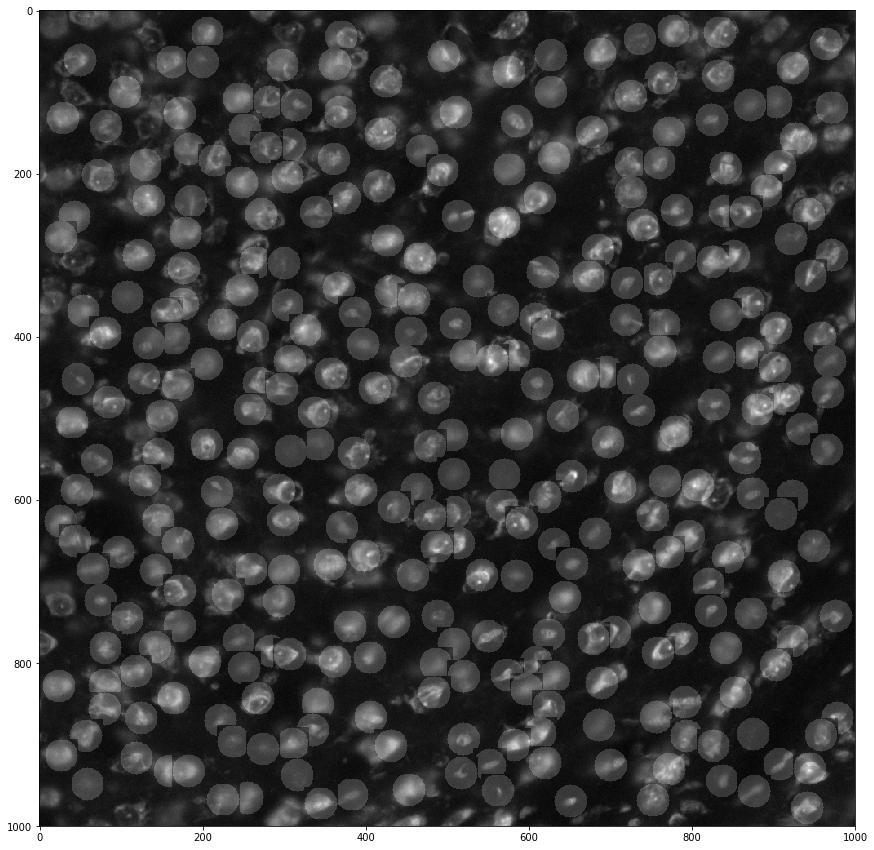

In [566]:
figure(figsize=[15,15])
imshow(markers+_mean,cmap='gray')

In [567]:
len(extracted)

316

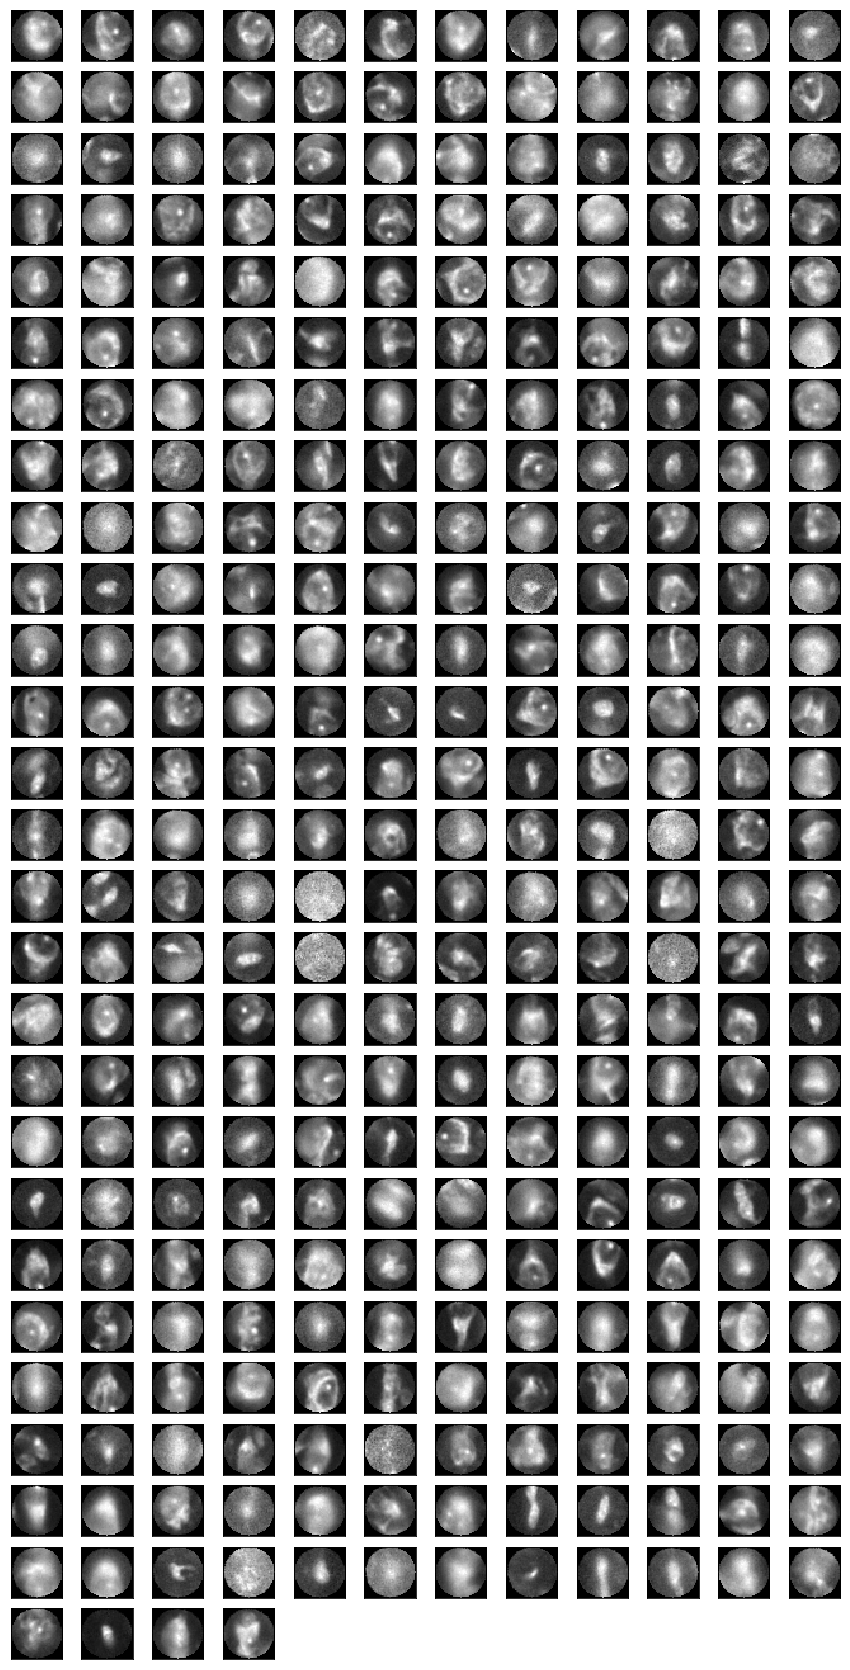

In [568]:
figure(figsize=(15,36))
for i in range(316):
    subplot(32,12,i+1);
    fig=imshow(extracted[i],cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)



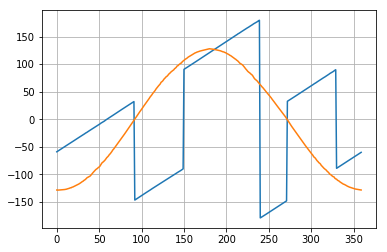

In [587]:
rows,cols = ex.shape
_diff=[]
_sign=[]
_log=[]
for ang in range(360):
    M = cv2.getRotationMatrix2D((cols/2,rows/2),ang,1)
    dst = cv2.warpAffine(ex,M,(cols,rows))
    diff = angle(dst)
    _diff.append(diff)
    _sign.append(s)
    #print(diff)
plot(_diff);
grid()
#xlim([10,360])
#ylim()
plot(100.*np.array(_log))

In [351]:
find(np.array(_log)<-100)

/Users/yoavfreund/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  """Entry point for launching an IPython kernel.


array([199, 217])

1.1620722550381513 -0.029853760374437543 1.1322184946637137


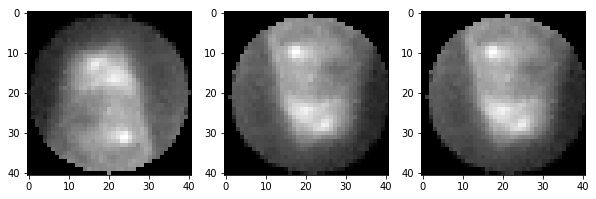

In [557]:
ex=extracted[10]
ang=angle(ex)
rotate=-180
M1 = cv2.getRotationMatrix2D((cols/2,rows/2),rotate,1)
dst= cv2.warpAffine(ex,M1,(cols,rows))
correction=angle(dst)-ang
M2 = cv2.getRotationMatrix2D((cols/2,rows/2),-correction,1)
restored = cv2.warpAffine(dst,M2,(cols,rows))
res_angle=angle(restored)

print(ang,correction,res_angle)

figure(figsize=[10,4])
subplot(1,3,1)
imshow(ex,cmap='gray')
subplot(1,3,2)
imshow(dst,cmap='gray')
subplot(1,3,3)
imshow(restored,cmap='gray')

17.05037241772151


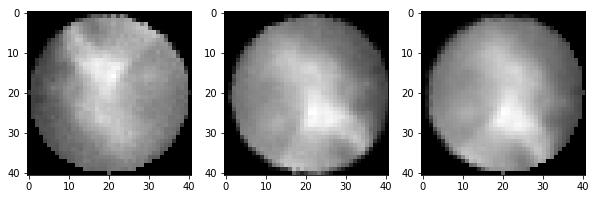

In [552]:
ex=extracted[12]
rotate=-164
M1 = cv2.getRotationMatrix2D((cols/2,rows/2),rotate,1)
rotated= cv2.warpAffine(ex,M1,(cols,rows))

ang,dst=normalize_angle(rotated)
print(ang)
figure(figsize=[10,4])
subplot(1,3,1)
imshow(ex,cmap='gray')
subplot(1,3,2)
imshow(rotated,cmap='gray')
subplot(1,3,3)
imshow(dst,cmap='gray')


